# ノートブック構成

0_データ確認  
1_環境変数の設定  
2_データ確認  
3_データ確認  
4_データ確認  


# 0_データ確認

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

dir_path = "./cifar_PNG_train"
fig = plt.figure(figsize=(25, 4))
category = os.listdir(dir_path)

<Figure size 2500x400 with 0 Axes>

In [2]:
category[0]

'0'

In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

classes[0]

'plane'

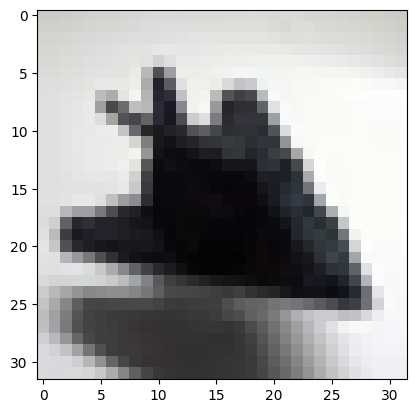

In [4]:
img_name = os.listdir(os.path.join(dir_path , category[0]))
im = Image.open(os.path.join(dir_path , category[0],img_name[0]))
plt.imshow(im)

In [5]:
print(im.size)

(32, 32)


# 1_環境変数の設定  

In [6]:
! ls -d */

cifar_PNG_test/  cifar_PNG_train/  data/  mnist_PNG_test/  mnist_PNG_train/


In [7]:
root_path = os.getcwd()
root_path

'/work'

In [8]:
import torch
print(torch.__version__)

1.13.1+cu117


In [9]:
import torchvision
print(torchvision.__version__)

0.14.1+cu117


In [10]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np
from tqdm import tqdm
import time
import copy
import os
import psutil
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
png_path = os.path.join(root_path,"cifar_PNG_train")

trans = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     #RGBを-1~1に変換
    ])

images = torchvision.datasets.ImageFolder(png_path, transform = trans)

batch_size = 64

n_samples = len(images)
train_size = int(n_samples * 0.8) 
val_size = n_samples - train_size 

# train validate data load
train_dataset, val_dataset = torch.utils.data.random_split(images, [train_size, val_size])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers=2)

# test data load
png_path = os.path.join(root_path,"cifar_PNG_test")
images_test = torchvision.datasets.ImageFolder(png_path, transform = trans)
testloader = torch.utils.data.DataLoader(images_test, batch_size = batch_size, shuffle = False, num_workers=2)

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,num_stop=10):
    
    train_preds_stack = []
    train_true_stack = []
    val_preds_stack = []
    val_true_stack = []

    train_loss_ls = []
    train_accuracy_ls = []
    val_loss_ls = []
    val_accuracy_ls = []

    epoch_num = []

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    
    model = model.to(device)
    
    early_stopping_count = 0
    
    for epoch in range(num_epochs):
        
        epoch_num.append(epoch)
        print('-' * 10)
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        mem = psutil.virtual_memory() 
        print("USE MEMORY = "+str(mem.percent)+" %")

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                
                total = 0
                correct = 0
                all_loss = 0
                for inputs, labels in trainloader:
                    
                    optimizer.zero_grad()
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                                        
                    loss.backward()
                    optimizer.step()
                                        
                    total += labels.size(0)
                    correct += (preds == labels).sum().item()
                    all_loss += loss.item()
                
                res_loss = (all_loss)# / total
                res_acc = (100 * correct / total)
                
                train_loss_ls.append(res_loss)
                train_accuracy_ls.append(res_acc)
                
                scheduler.step()
                print(" train_Loss: " + str(round(res_loss,5)) + " train_Acc: " + str(res_acc))

            else:
                model.eval()

                with torch.set_grad_enabled(phase == 'val'):
                    
                    total = 0
                    correct = 0
                    all_loss = 0
                    
                    for inputs, labels in valloader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                                       
                        total += labels.size(0)
                        correct += (preds == labels).sum().item()
                        all_loss += loss.item()
                
                    res_loss = (all_loss) # / total
                    res_acc = (100 * correct / total)
                    
                    val_loss_ls.append(res_loss)
                    val_accuracy_ls.append(res_acc)
                    
                    epoch_loss = res_loss
                    epoch_acc = res_acc
                                        
                    print(" val_Loss: " + str(round(epoch_loss,5)) + " val_Acc: " + str(epoch_acc))
  
            # deep copy the model
        #print("ep="+str(epoch_acc)+" best ="+str(best_acc))
        if epoch_acc > best_acc:    
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
                
            save_path = './loop_weight.pth'
            torch.save(model.state_dict(), save_path)
            ##############
        
        #print("ep="+str(round(epoch_loss,3))+" best ="+str(round(best_loss,3)))
        
        print("stop count = "+ str(early_stopping_count) + "/" + str(num_stop))
        if round(best_loss,3)>round(epoch_loss,3) :
            best_loss = epoch_loss
        else:
            early_stopping_count += 1   
            if early_stopping_count>num_stop:
                break
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    plt.subplot(1,2,1)
    #plt.figure()
    #plt.title("Learning Curve")
    plt.xlabel("epoch")
    #plt.ylabel("loss")
    
    plt.plot(epoch_num, train_loss_ls, 'o-', color="r", label="Training loss")
    plt.plot(epoch_num, val_loss_ls, 'o-', color="g", label="Validation loss")
    #plt.legend(loc='upper left')
    
    plt.subplot(1,2,2)
    plt.xlabel("epoch")
    #plt.ylabel("acc")
    
    plt.plot(epoch_num, train_accuracy_ls, 'o-', color="r", label="Training acc")
    plt.plot(epoch_num, val_accuracy_ls, 'o-', color="g", label="Validation acc")
    plt.legend(loc='upper left')
    
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    print("Done. load best-model weight.")
    return model

In [13]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# freeze layers except last layer
for param in model_ft.parameters():
    param.requires_grad = True

last_layer = list(model_ft.children())[-1]

print(f'except last layer: {last_layer}')
for param in last_layer.parameters():
    param.requires_grad = True

except last layer: Linear(in_features=512, out_features=10, bias=True)


In [15]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

----------
Epoch 0/49
----------
USE MEMORY = 13.2 %
 train_Loss: 679.4082 train_Acc: 63.0125
 val_Loss: 132.46193 val_Acc: 71.49
stop count = 0/10
----------
Epoch 1/49
----------
USE MEMORY = 19.9 %
 train_Loss: 429.96382 train_Acc: 76.9725
 val_Loss: 97.364 val_Acc: 78.53
stop count = 0/10
----------
Epoch 2/49
----------
USE MEMORY = 19.9 %
 train_Loss: 325.76937 train_Acc: 82.375
 val_Loss: 95.70318 val_Acc: 79.26
stop count = 0/10
----------
Epoch 3/49
----------
USE MEMORY = 19.9 %
 train_Loss: 255.13324 train_Acc: 86.0525
 val_Loss: 96.84498 val_Acc: 79.55
stop count = 0/10
----------
Epoch 4/49
----------
USE MEMORY = 19.9 %
 train_Loss: 207.3511 train_Acc: 88.6575
 val_Loss: 95.58019 val_Acc: 80.1
stop count = 1/10
----------
Epoch 5/49
----------
USE MEMORY = 19.9 %
 train_Loss: 169.62386 train_Acc: 90.6475
 val_Loss: 118.30842 val_Acc: 77.22
stop count = 1/10
----------
Epoch 6/49
----------
USE MEMORY = 19.9 %
 train_Loss: 145.14797 train_Acc: 92.145
 val_Loss: 107.71252 v

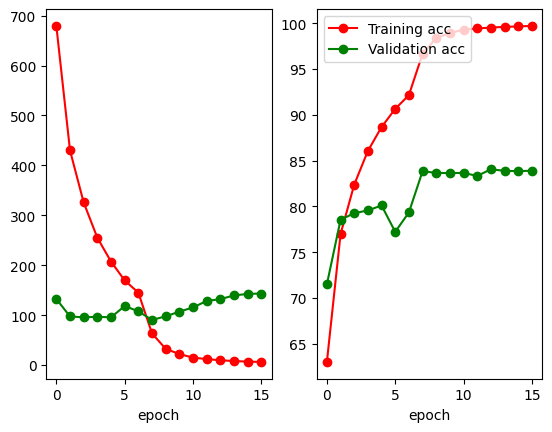

Done. load best-model weight.


In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50,num_stop=10)

In [17]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
                
        labels = labels.to(torch.device('cuda'))
        images = images.to(torch.device('cuda'))
        
        outputs = model_ft(images)
        
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 86.2 %
Accuracy for class: car   is 90.5 %
Accuracy for class: bird  is 79.0 %
Accuracy for class: cat   is 69.9 %
Accuracy for class: deer  is 81.6 %
Accuracy for class: dog   is 73.3 %
Accuracy for class: frog  is 89.4 %
Accuracy for class: horse is 84.0 %
Accuracy for class: ship  is 91.6 %
Accuracy for class: truck is 87.9 %


In [19]:

stack_pred_label = []
stack_true_label = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        labels = labels.to(torch.device('cuda'))
        images = images.to(torch.device('cuda'))
        
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        
        stack_true_label.extend(np.array(labels.detach().cpu().numpy()))

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        stack_pred_label.extend(np.array(predicted.detach().cpu().numpy()))
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
        
        

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

cm = confusion_matrix(stack_true_label, stack_pred_label)
#plot_confusion_matrix(conf_mat=cm)

Accuracy of the network on the 10000 test images: 83 %


In [20]:
stack_true_label

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [21]:
stack_pred_label

[0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 8,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 4,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 7,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 9,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 8,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 8,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 8,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


(<Figure size 2000x2000 with 2 Axes>,
 <AxesSubplot: xlabel='predicted label', ylabel='true label'>)

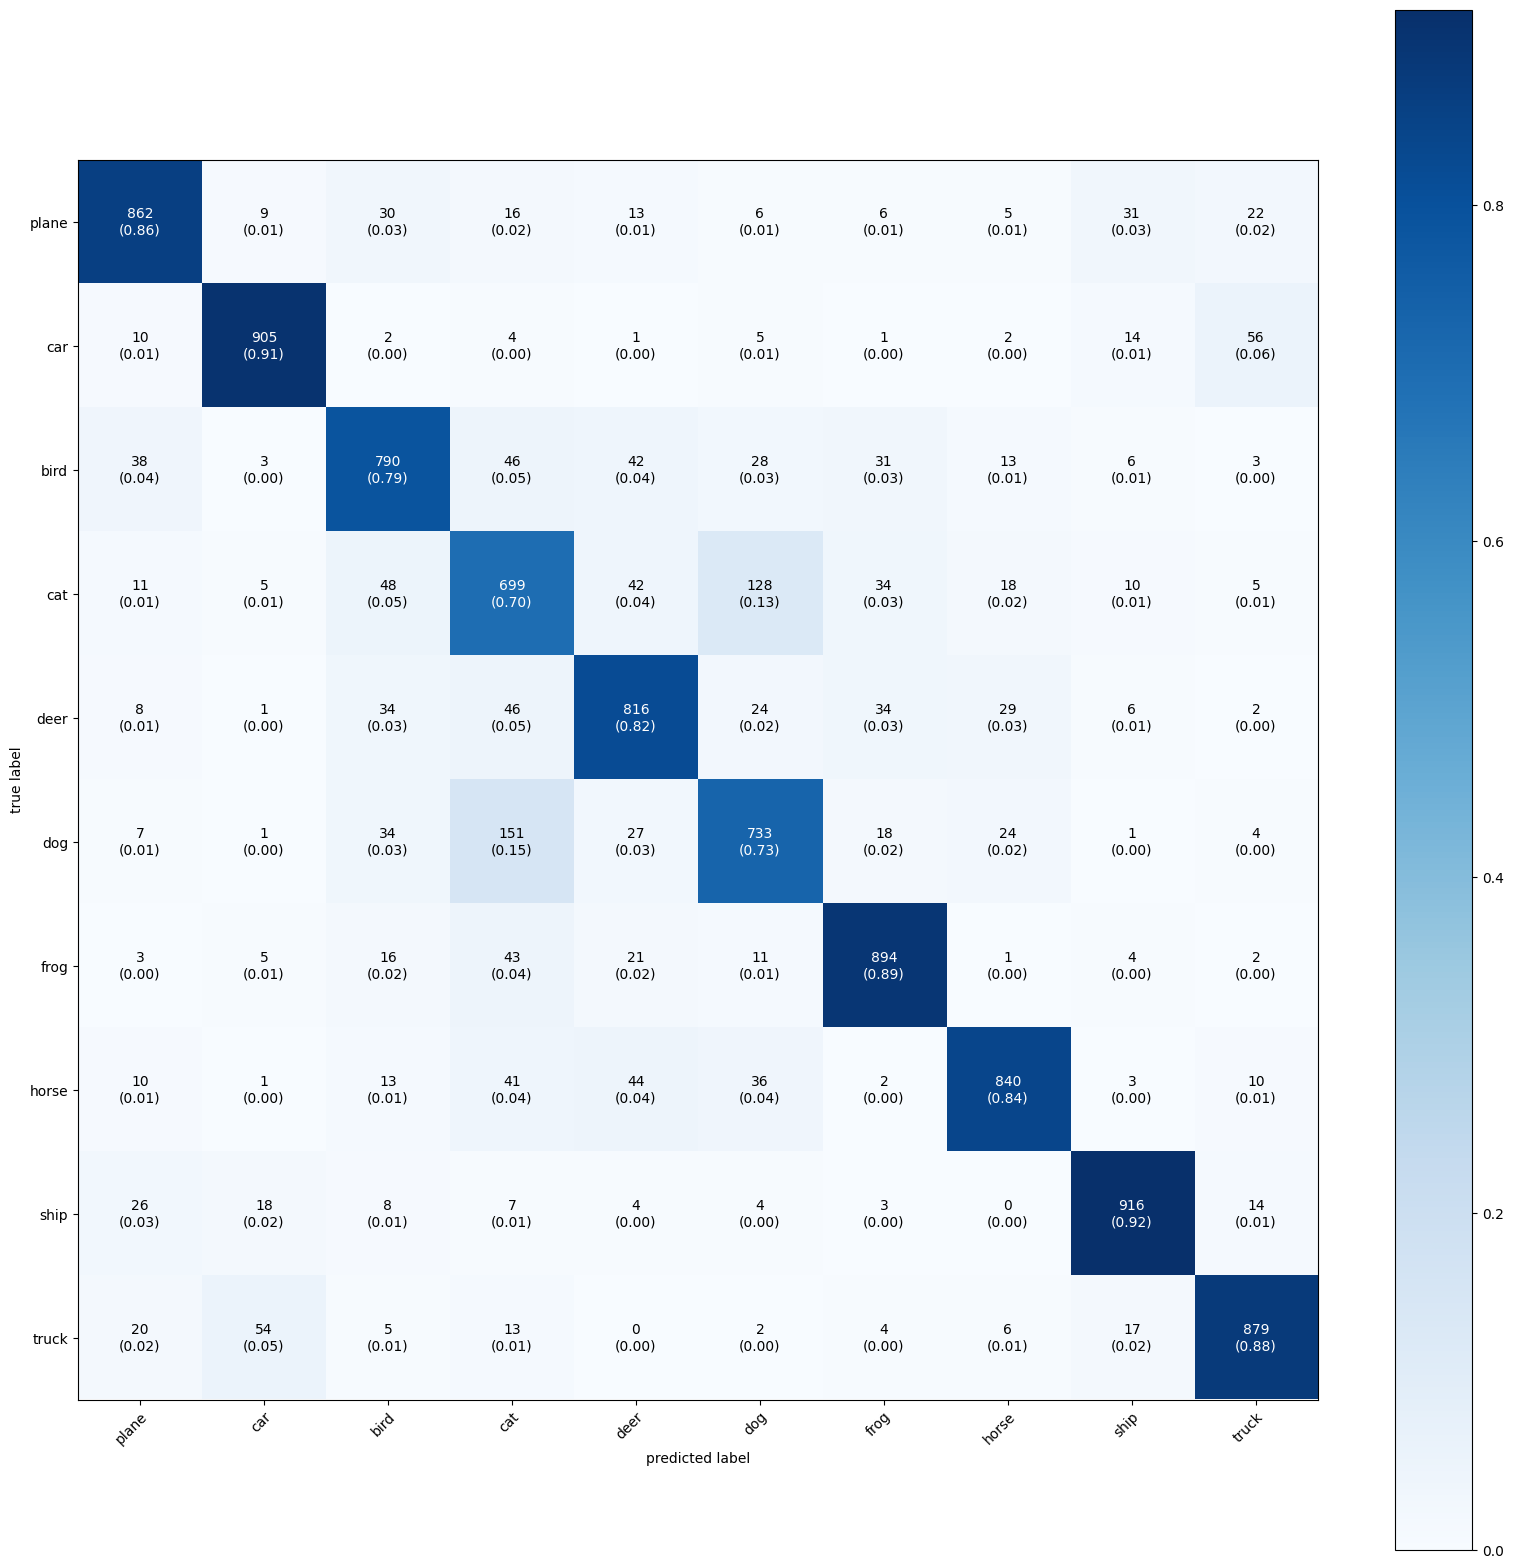

In [22]:
class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                      class_names=class_names, 
                      figsize=(20, 20), 
                      cmap='Blues')

In [23]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(testloader)
images, labels = next(dataiter)

labels = labels.to(torch.device('cuda'))
images = images.to(torch.device('cuda'))

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

GroundTruth:  plane plane plane plane


In [24]:

def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    def_img = img.detach().clone()
    for t, m, s in zip(def_img, mean, std):
        t.detach()
        t.mul_(s).add_(m)
    return def_img

im1 = torchvision.transforms.ToPILImage()(unnorm(images[0])).resize((100,100))
im2 = torchvision.transforms.ToPILImage()(unnorm(images[1])).resize((100,100))
im3 = torchvision.transforms.ToPILImage()(unnorm(images[2])).resize((100,100))
im4 = torchvision.transforms.ToPILImage()(unnorm(images[3])).resize((100,100))

def get_concat_h(im1, im2,im3,im4):
    dst = Image.new('RGB', (im1.width + im2.width +  im3.width + im4.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    dst.paste(im3, (im1.width + im2.width, 0))
    dst.paste(im4, (im1.width + im2.width + im3.width, 0))
    return dst


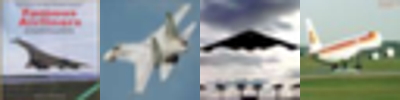

In [25]:
get_concat_h(im1, im2,im3,im4)
#.save('data/dst/pillow_concat_h.jpg')

In [26]:

outputs = model_ft(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  plane plane plane plane
